# Exploring Models for Predicting the SP500 Index at a Monthly-Level

0. **[Part 0: Set Up and Import](#part0)**
- **Objective**: Initialize programming environment and data.
- **Tasks:**
  - Initialize libraries.
  - Import data into the programming environment.

1. **[Part 1: EDA and Data Processing](#part1)**
- **Objective**: Perform Exploratory Data Analysis and Data Preprocessing
- **Tasks:**
   - Explore Data
   - Conduct preprocessing & Feature Engineering
   - Feature creation: Create multiple types of lag variables for different lag amounts.

2. **[Part 2: ARMA Model](#part2)**
- **Objective**: Discuss modeling aspects and compare methods.
- **Tasks:**
  - Create an ARMA model as a Baseline Model to Compare with more Advanced Models

3. **[Part 3: Gaussian Process Model](#part3)**
- **Objective**: Create a neural network and a gaussian process regression to model return, price, or direction (up or down).
- **Tasks:**
  - Feature selection: Random Forest Feature Selection
  - Create a gaussian process, discuss hyper parameter tuning.

4. **[Part 4: Neural Network Model](#part4)**
- **Objective**: Create a neural network and a gaussian process regression to model return, price, or direction (up or down).
- **Tasks:**
  - Feature selection: Random Forest Feature Selection
  - Create a neural network, discuss hyper parameter tuning.

## <a id='part0'>Part 0: Set Up and Import</a>
- **Objective**: Initialize programming environment and data.
- **Tasks:**
  - Initialize libraries.
  - Import data into the programming environment.
  - Conduct preprocessing.

In [108]:
#Libraries
import pandas as pd
import numpy as np
import datetime

from fancyimpute import KNN
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.gaussian_process.kernels import DotProduct, ConstantKernel as C, RationalQuadratic, ExpSineSquared, RBF, Sum, Product, WhiteKernel, ConstantKernel, Matern
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.metrics import precision_score, explained_variance_score, accuracy_score, classification_report, roc_auc_score, accuracy_score, log_loss, mean_squared_error, mean_absolute_error, r2_score, mean_squared_log_error
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, f_regression

# # statsmodels for statistical methods
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.api as sm
# from statsmodels.stats.diagnostic import het_arch
# import statsmodels.tsa.stattools as tsa
# import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
# from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# # scipy stats for shapiro test
# from scipy import stats
# from arch import arch_model

#Paths
data_path = "/Users/amberwalker/SP500-Prediction-NN-GP/data/"

## <a id='part1'> Part 1: EDA and Data Processing</a>
- **Objective**: Perform Exploratory Data Analysis and Data Preprocessing
- **Tasks:**
   - Explore Data
   - Conduct preprocessing & Feature Engineering
   - Feature creation: Create multiple types of lag variables for different lag amounts.

### Load and Clean Data

In [14]:
sp500_data = pd.read_csv(data_path + 'goyal-welch2022Monthly.csv', sep=',')
sp500_data.columns = sp500_data.columns.str.lower().str.strip()
sp500_data['date'] = pd.to_datetime(sp500_data['yyyymm'], format='%Y%m')
sp500_data['index'] = sp500_data['index'].astype(str).str.replace(',', '').astype(float)
sp500 = sp500_data[sp500_data['date'] >= '1926-01-01']

sp500_head = sp500.head()
sp500_info = sp500.info()
sp500_description = sp500.describe()

sp500_head, sp500_info, sp500_description

<class 'pandas.core.frame.DataFrame'>
Index: 1164 entries, 660 to 1823
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   yyyymm      1164 non-null   int64         
 1   index       1164 non-null   float64       
 2   d12         1164 non-null   float64       
 3   e12         1164 non-null   float64       
 4   b/m         1164 non-null   float64       
 5   tbl         1164 non-null   float64       
 6   aaa         1164 non-null   float64       
 7   baa         1164 non-null   float64       
 8   lty         1164 non-null   float64       
 9   ntis        1153 non-null   float64       
 10  rfree       1164 non-null   float64       
 11  infl        1164 non-null   float64       
 12  ltr         1164 non-null   float64       
 13  corpr       1164 non-null   float64       
 14  svar        1164 non-null   float64       
 15  csp         788 non-null    float64       
 16  crsp_spvw   1164 non-null  

(     yyyymm  index     d12    e12       b/m     tbl     aaa     baa     lty  \
 660  192601  12.74  0.6075  1.249  0.387671  0.0349  0.0482  0.0609  0.0374   
 661  192602  12.18  0.6150  1.248  0.394363  0.0318  0.0477  0.0602  0.0372   
 662  192603  11.46  0.6225  1.248  0.494091  0.0314  0.0479  0.0605  0.0371   
 663  192604  11.72  0.6300  1.247  0.482917  0.0308  0.0474  0.0598  0.0368   
 664  192605  11.81  0.6375  1.246  0.483860  0.0317  0.0471  0.0586  0.0369   
 
      ntis     rfree      infl     ltr   corpr      svar  csp  crsp_spvw  \
 660   NaN  0.002925  0.000000  0.0138  0.0072  0.000857  NaN  -0.001783   
 661   NaN  0.002908  0.000000  0.0063  0.0045  0.001099  NaN  -0.033296   
 662   NaN  0.002650 -0.005587  0.0041  0.0084  0.006016  NaN  -0.057708   
 663   NaN  0.002617  0.005618  0.0076  0.0097  0.001466  NaN   0.038522   
 664   NaN  0.002567 -0.005587  0.0014  0.0044  0.000690  NaN   0.013623   
 
      crsp_spvwx       date  
 660   -0.003980 1926-01-01  


In [10]:
sp500.isna().sum()

yyyymm          0
index           0
d12             0
e12             0
b/m             0
tbl             0
aaa             0
baa             0
lty             0
ntis           11
rfree           0
infl            0
ltr             0
corpr           0
svar            0
csp           376
crsp_spvw       0
crsp_spvwx      0
date            0
dtype: int64

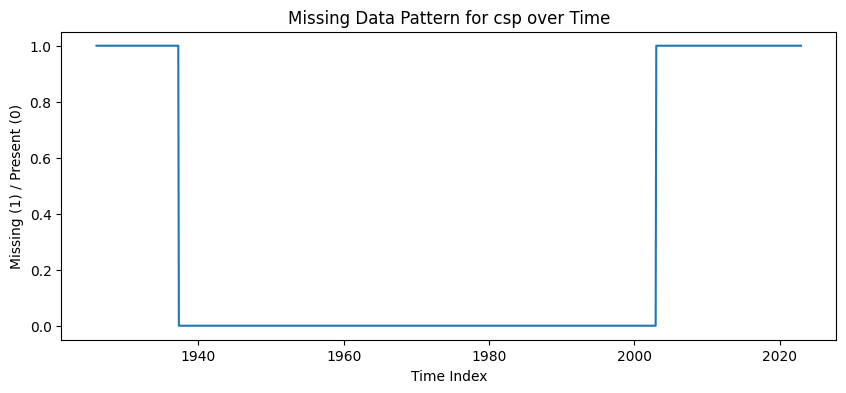

In [8]:
missing_csp = sp500['csp'].isna()
missing = missing_csp.astype(int)

plt.figure(figsize=(10, 4))
sns.lineplot(x=sp500['date'], y=missing) # Replace 'time_index' if needed
plt.xlabel("Time Index") # Adjust if using a different x-axis variable
plt.ylabel("Missing (1) / Present (0)")
plt.title("Missing Data Pattern for csp over Time")
plt.show()


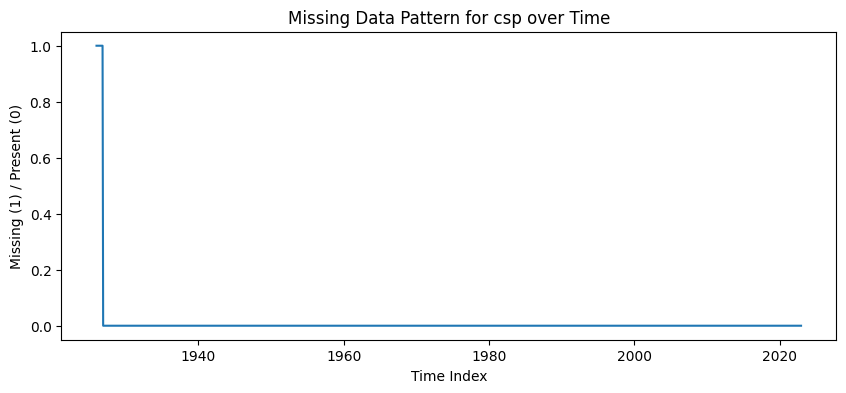

In [11]:
missing_csp = sp500['ntis'].isna()
missing = missing_csp.astype(int)

plt.figure(figsize=(10, 4))
sns.lineplot(x=sp500['date'], y=missing) # Replace 'time_index' if needed
plt.xlabel("Time Index") # Adjust if using a different x-axis variable
plt.ylabel("Missing (1) / Present (0)")
plt.title("Missing Data Pattern for csp over Time")
plt.show()

### Explore the Target Variables

In [77]:
#create the return variable
sp500['index_return'] = sp500['index'].pct_change()  #percentage change

/var/folders/9c/ynj2mpvs1c71tlzpt943ljc40000gn/T/ipykernel_22625/4217232059.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500['index_return'] = sp500['index'].pct_change()  #percentage change


<Axes: title={'center': 'Return'}>

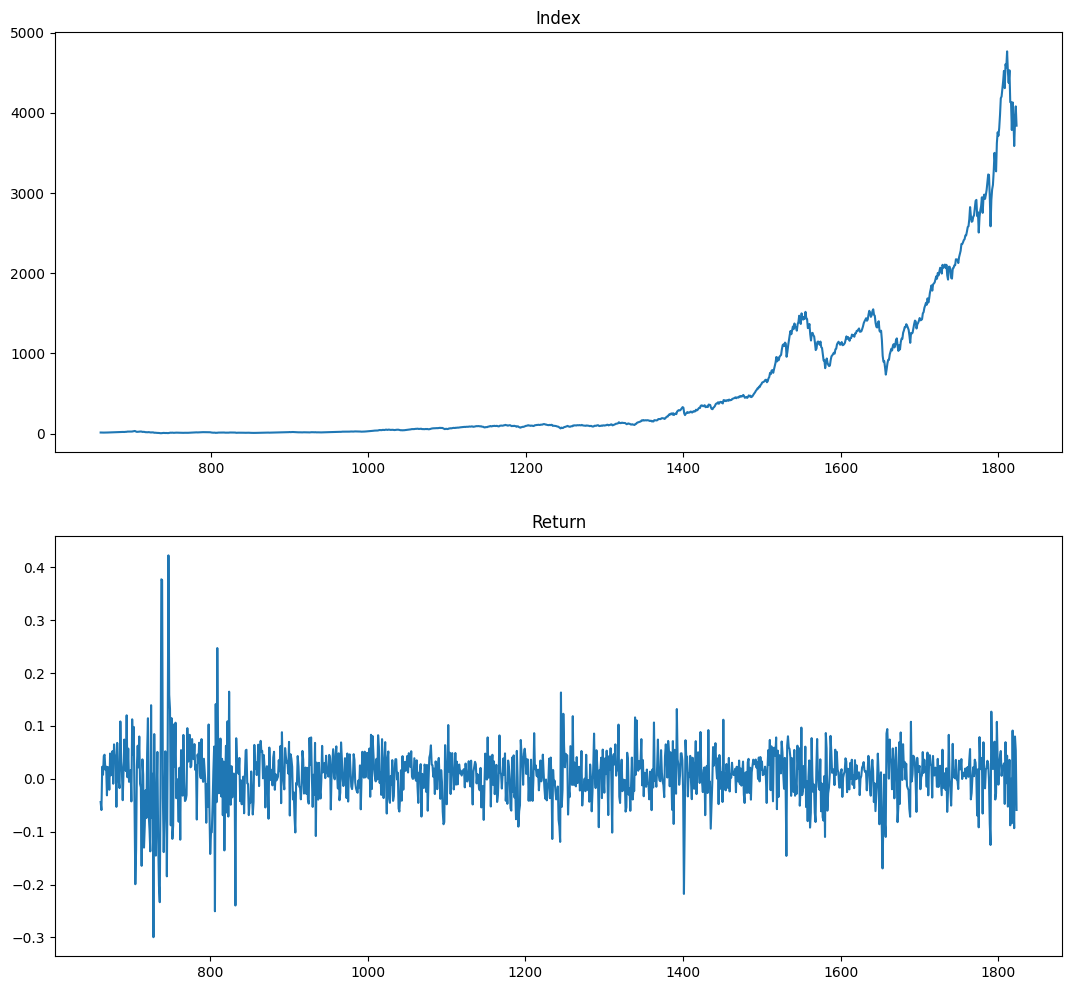

In [78]:
fig, ax = plt.subplots(2, 1, figsize=(13, 12))
sp500['index'].plot(ax=ax[0], title="Index")
sp500['index_return'].plot(ax=ax[1], title="Return")

We can see that the return target variable is already stationary, but the index (price) is not, so we will work to fix that.

/var/folders/9c/ynj2mpvs1c71tlzpt943ljc40000gn/T/ipykernel_22625/1898679800.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500['first_diff'] = sp500['index'] - sp500['index'].shift()


<Axes: >

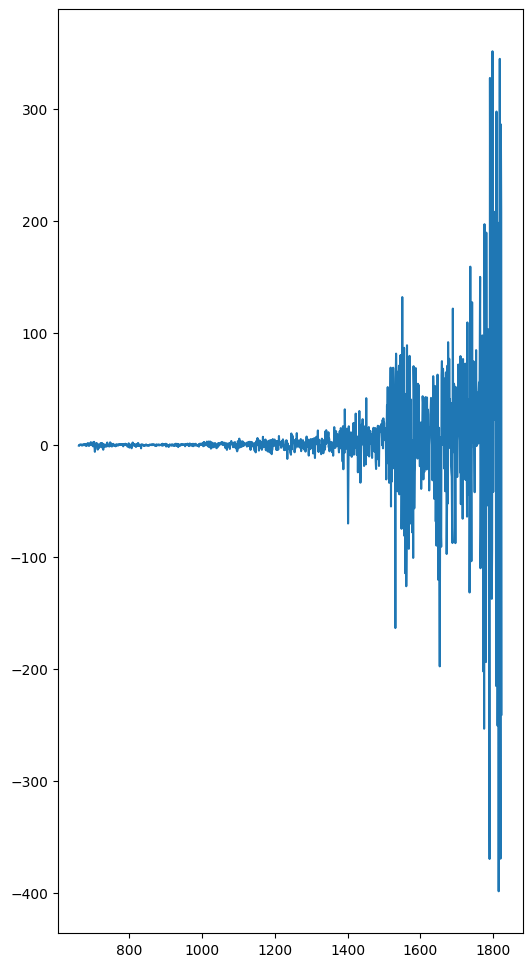

In [ ]:
sp500['first_diff'] = sp500['index'] - sp500['index'].shift()
sp500['first_diff'].plot(figsize=(6, 12))


Dat is no longer trending up and is instead centered aroudn zero, but variance is small in the beginning then increases expoenentially. Let's apply a log transformation.

/var/folders/9c/ynj2mpvs1c71tlzpt943ljc40000gn/T/ipykernel_22625/565044715.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500['nat_log_index'] = sp500['index'].apply(lambda x: np.log(x))


<Axes: >

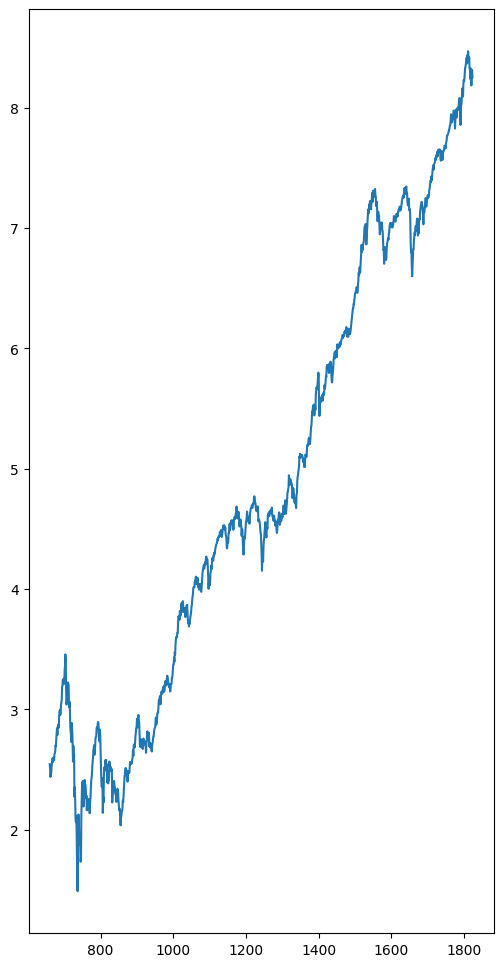

In [50]:
sp500['nat_log_index'] = sp500['index'].apply(lambda x: np.log(x))
sp500['nat_log_index'].plot(figsize=(6, 12))


we falttened the exp curve to a linear curve which will make our time series forcast much easier

/var/folders/9c/ynj2mpvs1c71tlzpt943ljc40000gn/T/ipykernel_22625/1592167108.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500['og_var'] = sp500['index'].rolling(window=30, center=True).var()
/var/folders/9c/ynj2mpvs1c71tlzpt943ljc40000gn/T/ipykernel_22625/1592167108.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500['log_var'] = sp500['nat_log_index'].rolling(window=30, center=True).var()


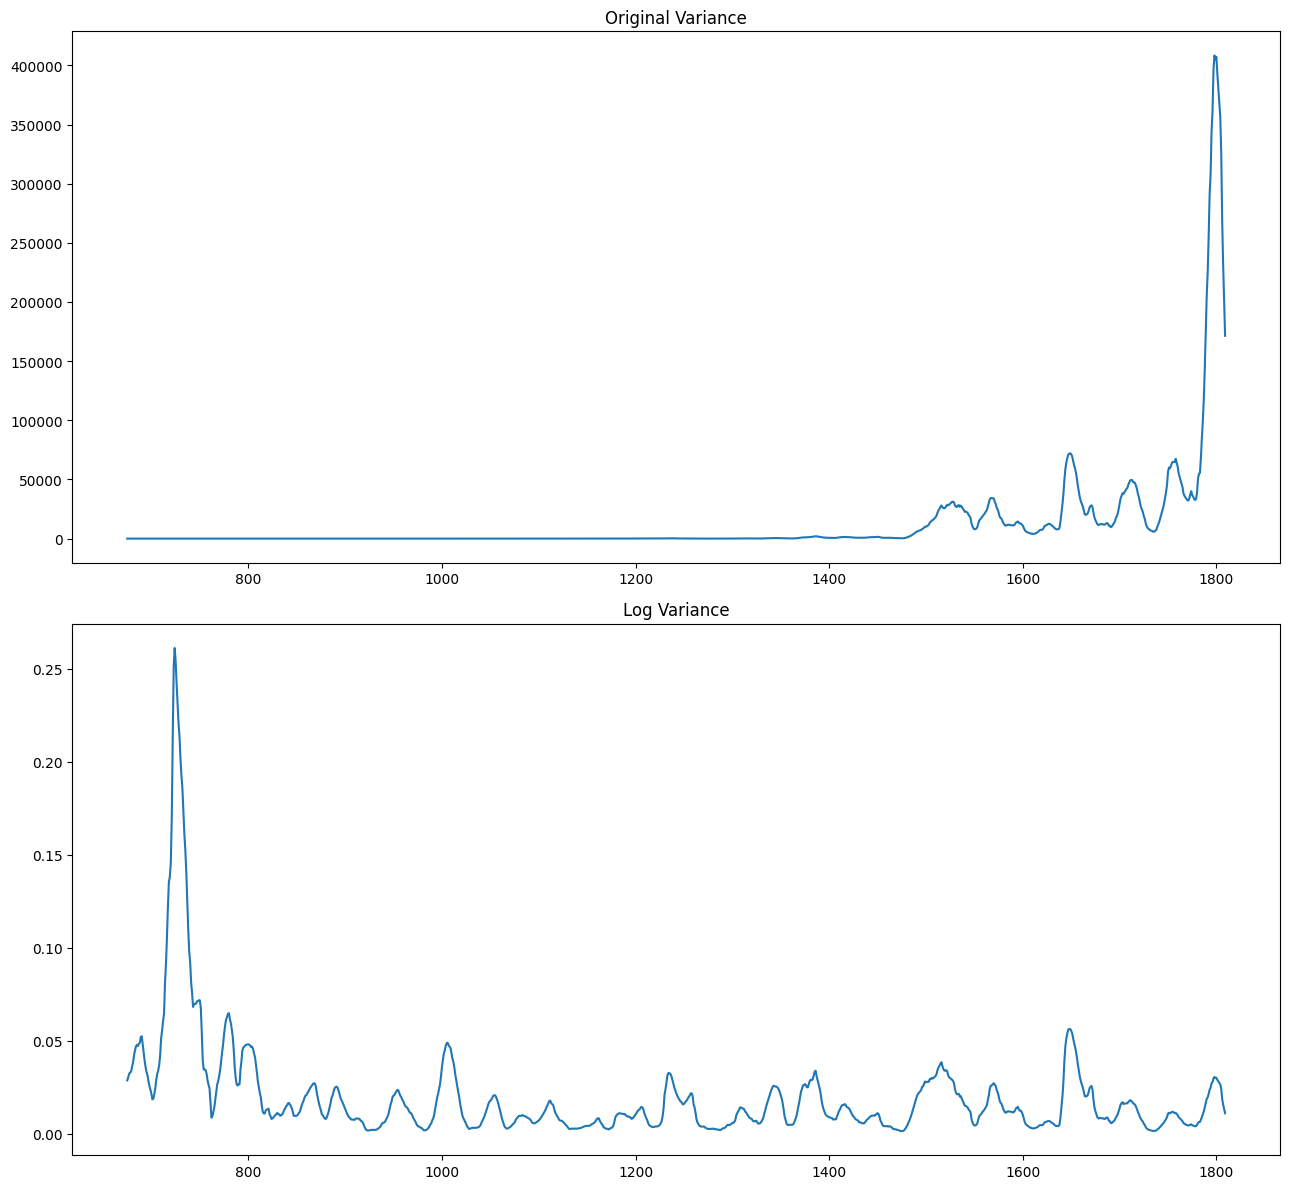

In [53]:
sp500['og_var'] = sp500['index'].rolling(window=30, center=True).var()

sp500['log_var'] = sp500['nat_log_index'].rolling(window=30, center=True).var()

fig, ax = plt.subplots(2, 1, figsize=(13, 12))
sp500['og_var'].plot(ax=ax[0], title="Original Variance")
sp500['log_var'].plot(ax=ax[1], title="Log Variance")
fig.tight_layout()

We can see that the log transformation helped makes the differences in values more clear.
Now we still need to take the difference of the log transformation, let's do that.

/var/folders/9c/ynj2mpvs1c71tlzpt943ljc40000gn/T/ipykernel_22625/1486465608.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500['logged_first_diff'] = sp500['nat_log_index'] - sp500['nat_log_index'].shift()


<Axes: >

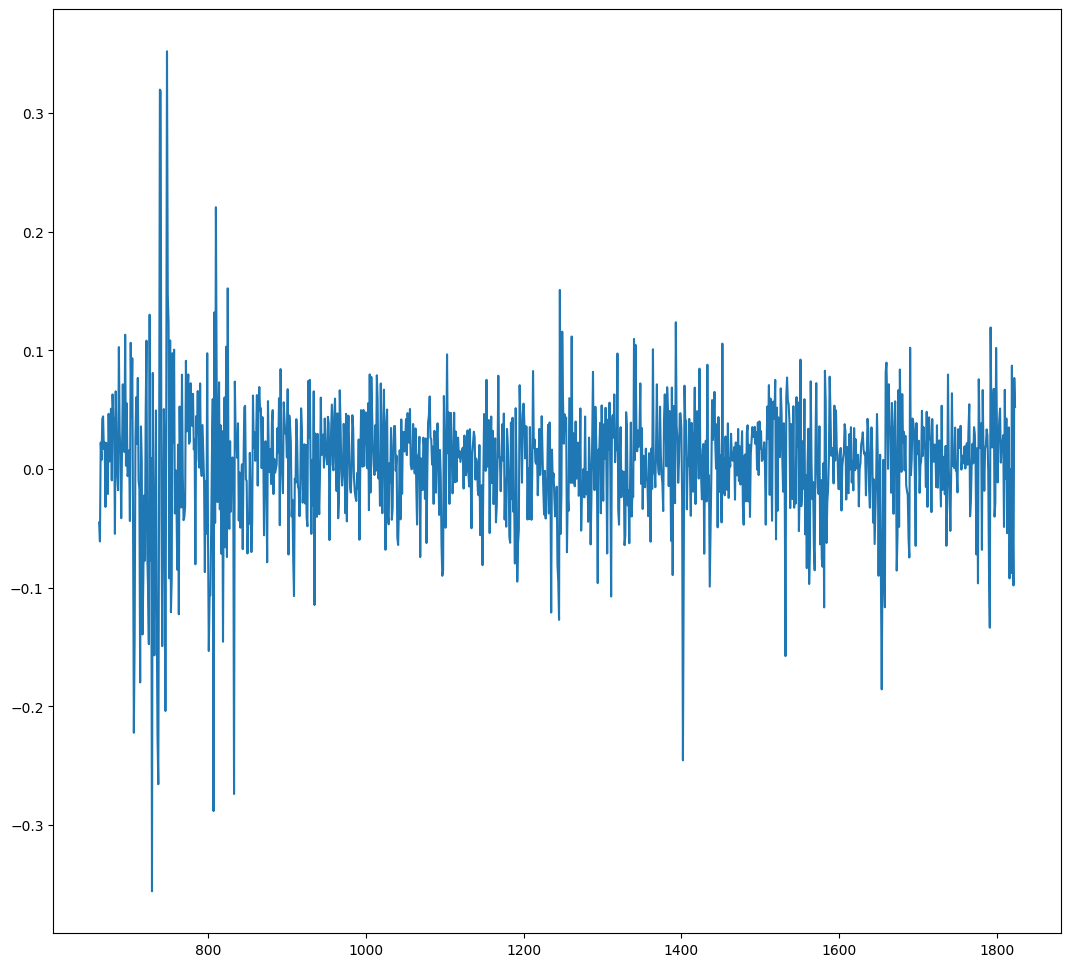

In [59]:
sp500['logged_first_diff'] = sp500['nat_log_index'] - sp500['nat_log_index'].shift()
sp500['logged_first_diff'].plot(figsize=(13, 12))

Now we have a stationary time series model of the mothly changes to the S&P index

Now let's check if there are any correlations between index and the lags of the variable an auto-correlation function.

In [64]:
print(sp500['logged_first_diff'].head())
print(sp500['logged_first_diff'].describe())


660         NaN
661         NaN
662   -0.044951
663   -0.060933
664    0.022434
Name: logged_first_diff, dtype: float64
count    1162.000000
mean        0.004965
std         0.053974
min        -0.355851
25%        -0.019673
50%         0.009368
75%         0.035429
max         0.352221
Name: logged_first_diff, dtype: float64


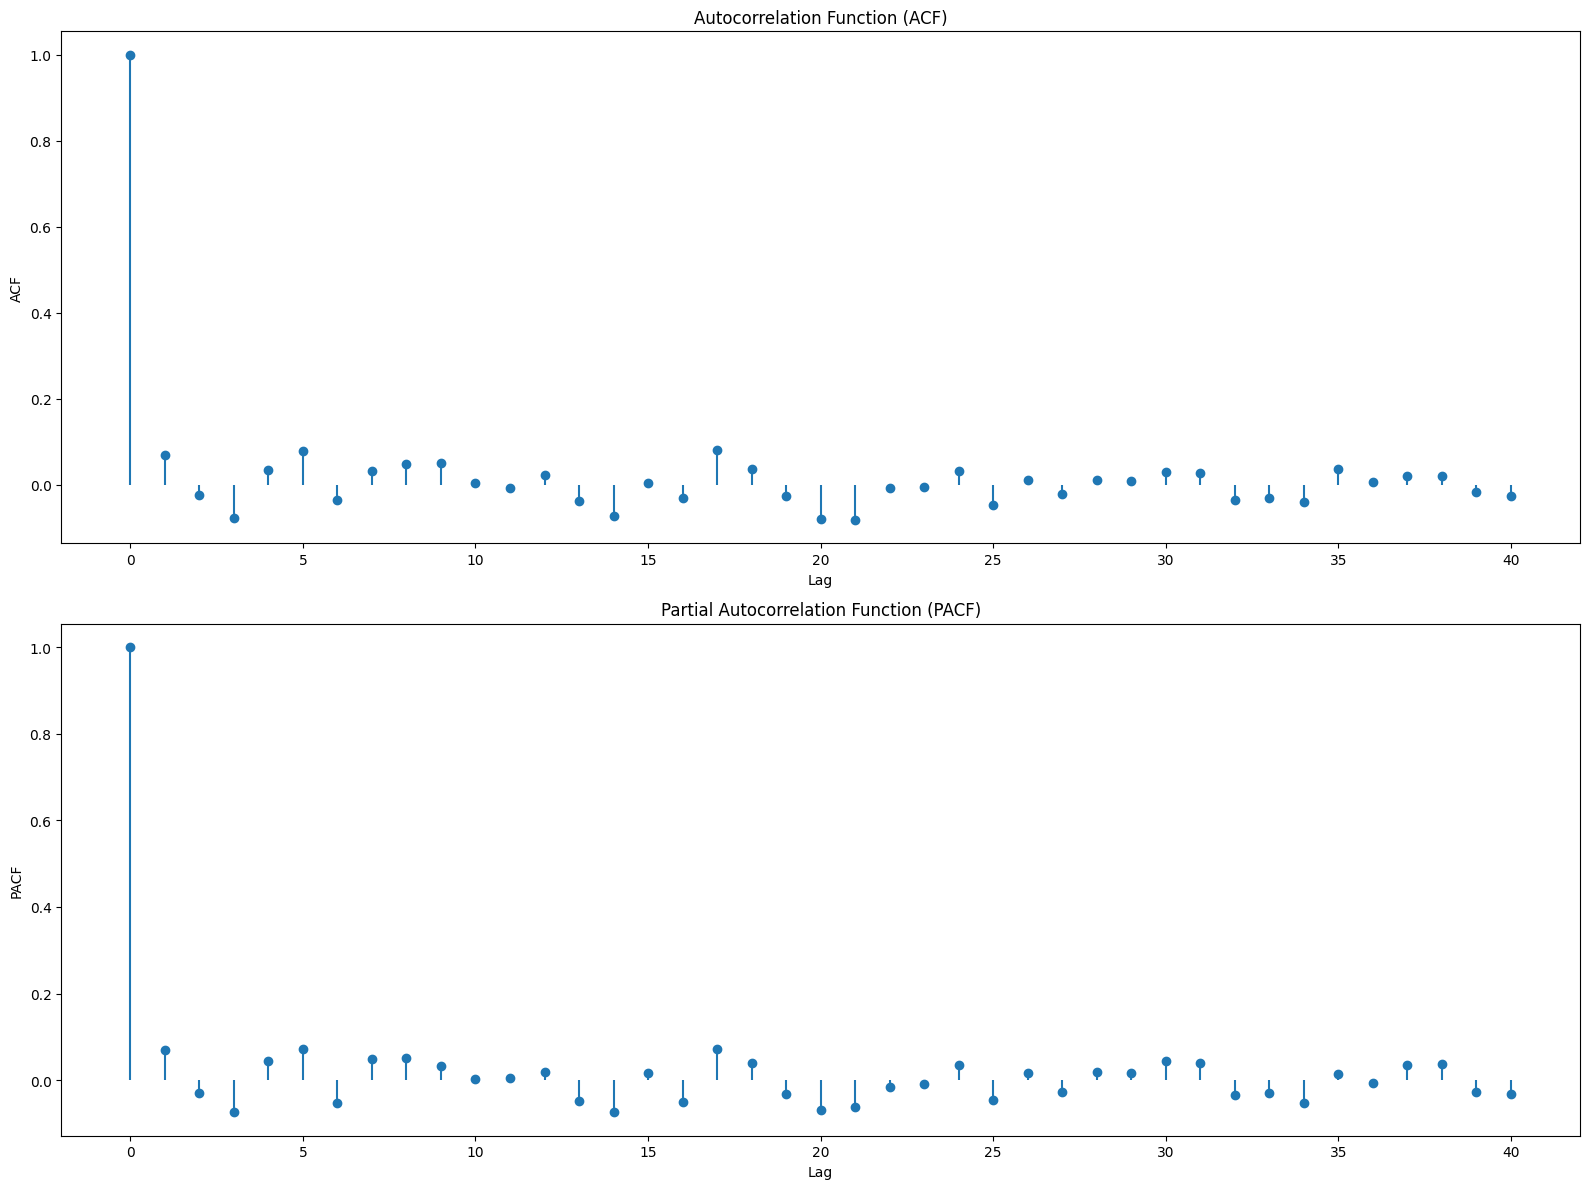

In [65]:
# Calculate ACF and PACF (exclude lag 0 for clarity in plotting)
lag_correlations = acf(sp500['logged_first_diff'].dropna(), nlags=40)
lag_partial_correlations = pacf(sp500['logged_first_diff'].dropna(), nlags=40)

# Plot ACF and PACF
fig, ax = plt.subplots(2, 1, figsize=(16, 12))

# Plot ACF
ax[0].stem(range(len(lag_correlations)), lag_correlations, basefmt=" ")
ax[0].set_title("Autocorrelation Function (ACF)")
ax[0].set_xlabel("Lag")
ax[0].set_ylabel("ACF")

# Plot PACF
ax[1].stem(range(len(lag_partial_correlations)), lag_partial_correlations, basefmt=" ")
ax[1].set_title("Partial Autocorrelation Function (PACF)")
ax[1].set_xlabel("Lag")
ax[1].set_ylabel("PACF")

plt.tight_layout()
plt.show()

All of the lags are under 0.2 indicating that none of them really have a stong correlation. Meaning the series is a random walk which makes sense, the stock market is not predictable.

### Feature Engineering

In [90]:
sp500.columns

Index(['yyyymm', 'index', 'd12', 'e12', 'b/m', 'tbl', 'aaa', 'baa', 'lty',
       'ntis', 'rfree', 'infl', 'ltr', 'corpr', 'svar', 'csp', 'crsp_spvw',
       'crsp_spvwx', 'date', 'first_diff', 'nat_log_index', 'og_var',
       'log_var', 'logged_first_diff', 'forecast', 'index_return'],
      dtype='object')

In [79]:
sp500_df = sp500.copy()
sp500_df['index'] = pd.to_numeric(sp500_df['index'], errors='coerce')
sp500_df['d12'] = pd.to_numeric(sp500_df['d12'], errors='coerce')
sp500_df['rfree'] = pd.to_numeric(sp500_df['rfree'], errors='coerce')

print(sp500_df.dtypes)

yyyymm                        int64
index                       float64
d12                         float64
e12                         float64
b/m                         float64
tbl                         float64
aaa                         float64
baa                         float64
lty                         float64
ntis                        float64
rfree                       float64
infl                        float64
ltr                         float64
corpr                       float64
svar                        float64
csp                         float64
crsp_spvw                   float64
crsp_spvwx                  float64
date                 datetime64[ns]
first_diff                  float64
nat_log_index               float64
og_var                      float64
log_var                     float64
logged_first_diff           float64
forecast                    float64
index_return                float64
dtype: object


In [80]:
# dividend-price ratio (dp)
sp500_df['dp'] = np.log(sp500_df['d12']) - np.log(sp500_df['index'])

# Book-to-Market (b/m)
sp500_df.rename(columns={'b/m': 'bm'}, inplace=True)

print(sp500_df)

      yyyymm    index      d12       e12        bm     tbl     aaa     baa  \
660   192601    12.74   0.6075    1.2490  0.387671  0.0349  0.0482  0.0609   
661   192602    12.18   0.6150    1.2480  0.394363  0.0318  0.0477  0.0602   
662   192603    11.46   0.6225    1.2480  0.494091  0.0314  0.0479  0.0605   
663   192604    11.72   0.6300    1.2470  0.482917  0.0308  0.0474  0.0598   
664   192605    11.81   0.6375    1.2460  0.483860  0.0317  0.0471  0.0586   
...      ...      ...      ...       ...       ...     ...     ...     ...   
1819  202208  3955.00  64.8854  188.8067  0.227429  0.0263  0.0407  0.0515   
1820  202209  3585.62  65.3183  187.0800  0.249478  0.0313  0.0459  0.0569   
1821  202210  3871.98  65.8531  182.3033  0.218935  0.0372  0.0510  0.0626   
1822  202211  4080.11  66.3880  177.5267  0.207182  0.0415  0.0490  0.0607   
1823  202212  3839.50  66.9228  172.7500  0.216199  0.0425  0.0443  0.0559   

         lty      ntis  ...  crsp_spvwx       date  first_diff 

In [82]:
sp500_df['logret'] = np.log(sp500_df['index']).diff() #log return of sp500
sp500_df['logindex'] = np.log(sp500_df['index']) #log of index

print(sp500_df[['date', 'logindex', 'logret']].head())

          date  logindex    logret
660 1926-01-01  2.544747       NaN
661 1926-02-01  2.499795 -0.044951
662 1926-03-01  2.438863 -0.060933
663 1926-04-01  2.461297  0.022434
664 1926-05-01  2.468947  0.007650


In [84]:
#lags for dp
sp500_df['dp_lag1'] = sp500_df['dp'].shift(1)
sp500_df['dp_lag2'] = sp500_df['dp'].shift(2)
sp500_df['dp_lag3'] = sp500_df['dp'].shift(3)
sp500_df['dp_lag4'] = sp500_df['dp'].shift(4)

#lags for svar
sp500_df['svar_lag1'] = sp500_df['svar'].shift(1)
sp500_df['svar_lag2'] = sp500_df['svar'].shift(2)
sp500_df['svar_lag3'] = sp500_df['svar'].shift(3)
sp500_df['svar_lag4'] = sp500_df['svar'].shift(4)

#lags for bm
sp500_df['bm_lag1'] = sp500_df['bm'].shift(1)
sp500_df['bm_lag2'] = sp500_df['bm'].shift(2)
sp500_df['bm_lag3'] = sp500_df['bm'].shift(3)
sp500_df['bm_lag4'] = sp500_df['bm'].shift(4)

#lags for target: log of price
sp500_df['logindex_lag1'] = sp500_df['logindex'].shift(1)
sp500_df['logindex_lag2'] = sp500_df['logindex'].shift(2)
sp500_df['logindex_lag3'] = sp500_df['logindex'].shift(3)
sp500_df['logindex_lag4'] = sp500_df['logindex'].shift(4)

#lags for target: log of return
sp500_df['logret_lag1'] = sp500_df['logret'].shift(1)
sp500_df['logret_lag2'] = sp500_df['logret'].shift(2)
sp500_df['logret_lag3'] = sp500_df['logret'].shift(3)
sp500_df['logret_lag4'] = sp500_df['logret'].shift(4)

sp500_df.head()

,yyyymm,index,d12,e12,bm,tbl,aaa,baa,lty,ntis,...,bm_lag3,bm_lag4,logindex_lag1,logindex_lag2,logindex_lag3,logindex_lag4,logret_lag1,logret_lag2,logret_lag3,logret_lag4
660,192601,12.74,0.6075,1.249,0.387671,0.0349,0.0482,0.0609,0.0374,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
661,192602,12.18,0.6150,1.248,0.394363,0.0318,0.0477,0.0602,0.0372,NaN,...,NaN,NaN,2.544747,NaN,NaN,NaN,NaN,NaN,NaN,NaN
662,192603,11.46,0.6225,1.248,0.494091,0.0314,0.0479,0.0605,0.0371,NaN,...,NaN,NaN,2.499795,2.544747,NaN,NaN,-0.044951,NaN,NaN,NaN
663,192604,11.72,0.6300,1.247,0.482917,0.0308,0.0474,0.0598,0.0368,NaN,...,0.387671,NaN,2.438863,2.499795,2.544747,NaN,-0.060933,-0.044951,NaN,NaN
664,192605,11.81,0.6375,1.246,0.483860,0.0317,0.0471,0.0586,0.0369,NaN,...,0.394363,0.387671,2.461297,2.438863,2.499795,2.544747,0.022434,-0.060933,-0.044951,NaN


In [91]:
sp500_df_filtered = sp500_df[sp500_df['date'] >= '1927-01-01']
sp500_nulls = sp500_df_filtered.isna().sum()
print(sp500_nulls)

yyyymm                 0
index                  0
d12                    0
e12                    0
bm                     0
tbl                    0
aaa                    0
baa                    0
lty                    0
ntis                   0
rfree                  0
infl                   0
ltr                    0
corpr                  0
svar                   0
csp                  364
crsp_spvw              0
crsp_spvwx             0
date                   0
first_diff             0
nat_log_index          0
og_var                17
log_var               17
logged_first_diff      0
forecast               0
index_return           0
dp                     0
logret                 0
logindex               0
dp_lag1                0
dp_lag2                0
dp_lag3                0
dp_lag4                0
svar_lag1              0
svar_lag2              0
svar_lag3              0
svar_lag4              0
bm_lag1                0
bm_lag2                0
bm_lag3                0


In [92]:
#save data
sp500_df_filtered.to_csv(data_path + 'sp500_clean.csv', index=False)

### Feature Selection

In [93]:
sp500_df_filtered.columns

Index(['yyyymm', 'index', 'd12', 'e12', 'bm', 'tbl', 'aaa', 'baa', 'lty',
       'ntis', 'rfree', 'infl', 'ltr', 'corpr', 'svar', 'csp', 'crsp_spvw',
       'crsp_spvwx', 'date', 'first_diff', 'nat_log_index', 'og_var',
       'log_var', 'logged_first_diff', 'forecast', 'index_return', 'dp',
       'logret', 'logindex', 'dp_lag1', 'dp_lag2', 'dp_lag3', 'dp_lag4',
       'svar_lag1', 'svar_lag2', 'svar_lag3', 'svar_lag4', 'bm_lag1',
       'bm_lag2', 'bm_lag3', 'bm_lag4', 'logindex_lag1', 'logindex_lag2',
       'logindex_lag3', 'logindex_lag4', 'logret_lag1', 'logret_lag2',
       'logret_lag3', 'logret_lag4'],
      dtype='object')

In [94]:
features = ['d12', 'e12', 'bm', 'tbl', 'aaa', 'baa',
       'lty', 'rfree', 'infl', 'ltr', 'corpr', 'svar',
       'crsp_spvw', 'crsp_spvwx', 'dp', 'dp_lag1', 'dp_lag2', 'dp_lag3', 'dp_lag4',
       'svar_lag1', 'svar_lag2', 'svar_lag3', 'svar_lag4', 'bm_lag1',
       'bm_lag2', 'bm_lag3', 'bm_lag4']

#prepare the data
train_data = sp500_df_filtered[sp500_df_filtered['date'] < '2018-01-01']
test_data = sp500_df_filtered[(sp500_df_filtered['date'] >= '2018-01-01') & (sp500_df_filtered['date'] <= '2021-12-31')]

X_train = train_data[features]
Y_train = {
    'logindex': train_data['logged_first_diff'],
    'logret': train_data['logret']
}

n_estimators = 100
top_n = 10
feature_importances = {}
top_features = {}

for target, y_train in Y_train.items():
    valid_idx = y_train.notna()
    model = RandomForestRegressor(n_estimators=n_estimators, random_state=42)
    model.fit(X_train[valid_idx], y_train[valid_idx])

    # Store and sort feature importances
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    feature_importances[target] = importances
    top_features[target] = X_train.columns[indices[:top_n]]

    print(f"Top {top_n} important features for {target}:", top_features[target])

Top 10 important features for logindex: Index(['svar', 'svar_lag1', 'bm_lag3', 'svar_lag2', 'dp_lag1', 'svar_lag3',
       'svar_lag4', 'infl', 'dp_lag2', 'ltr'],
      dtype='object')
Top 10 important features for logret: Index(['crsp_spvwx', 'crsp_spvw', 'bm_lag2', 'dp_lag3', 'bm_lag1', 'dp_lag2',
       'dp', 'svar', 'd12', 'ltr'],
      dtype='object')


## <a id='part2'>Part 2: Time Series Forecasting</a>
Earlier, during the EDA part, we discovered that was no the series is just a random walk and there are no correlations between index and its lags, but we can still move forward with fitting an ARIMA model.

/Users/amberwalker/SP500-Prediction-NN-GP/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Users/amberwalker/SP500-Prediction-NN-GP/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/Users/amberwalker/SP500-Prediction-NN-GP/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/var/folders/9c/ynj2mpvs1c71tlzpt943ljc40000gn/T/

<Axes: >

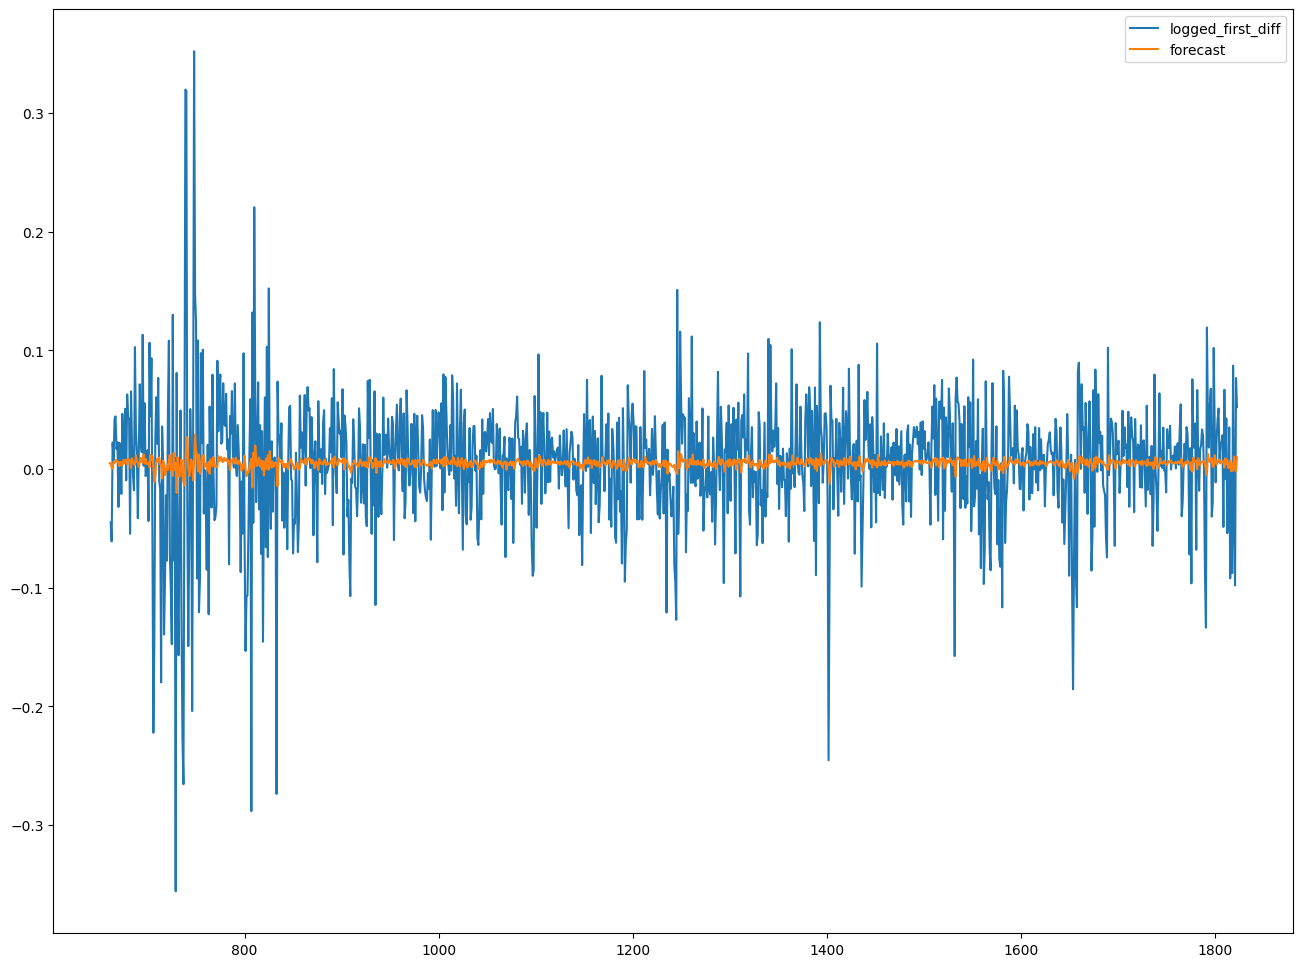

In [71]:
arima_model = sm.tsa.ARIMA(sp500['logged_first_diff'].iloc[1:],order=(1,0,0))
results = arima_model.fit()
sp500['forecast'] = results.fittedvalues
sp500[['logged_first_diff', 'forecast']].plot(figsize=(16,12))

The model seems to be able to predict tiny variation/movement, but for the most part it is not a very good forecast. Hence, the reason we will move on to machine learning models and see if we can get better forecasts.

## <a id='part3'> Part 3: Gaussian Process Model</a>
- **Objective**: Create a gaussian process regression to model price.
- **Tasks:**
  - GridSearch
  - Create a gaussian process
  - Train & Evaluate

#### GridSearch CV & Prediction -Continuous Targets



In [104]:
sp500_df_filtered['date'] = pd.to_datetime(sp500_df_filtered['date'])
train_data = sp500_df_filtered[sp500_df_filtered['date'] < '2022-01-01']
test_data = sp500_df_filtered[sp500_df_filtered['date'] >= '2022-01-01']

/var/folders/9c/ynj2mpvs1c71tlzpt943ljc40000gn/T/ipykernel_22625/594319792.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500_df_filtered['date'] = pd.to_datetime(sp500_df_filtered['date'])


In [89]:
sp500_df_filtered.columns

Index(['date', 'yyyymm', 'index', 'd12', 'e12', 'bm', 'tbl', 'aaa', 'baa',
       'lty', 'ntis', 'rfree', 'infl', 'ltr', 'corpr', 'svar', 'csp',
       'crsp_spvw', 'crsp_spvwx', 'logret', 'logindex', 'index_return',
       'direction', 'dp', 'dp_lag1', 'dp_lag2', 'dp_lag3', 'dp_lag4',
       'svar_lag1', 'svar_lag2', 'svar_lag3', 'svar_lag4', 'bm_lag1',
       'bm_lag2', 'bm_lag3', 'bm_lag4', 'logindex_lag1', 'logindex_lag2',
       'logindex_lag3', 'logindex_lag4', 'logret_lag1', 'logret_lag2',
       'logret_lag3', 'logret_lag4', 'direction_lag1', 'direction_lag2',
       'direction_lag3', 'direction_lag4'],
      dtype='object')

In [98]:
targets = ['logindex', 'logret']
top_features_cont = {key: top_features[key] for key in targets}

print(top_features_cont)

{'logindex': Index(['svar', 'svar_lag1', 'bm_lag3', 'svar_lag2', 'dp_lag1', 'svar_lag3',
       'svar_lag4', 'infl', 'dp_lag2', 'ltr'],
      dtype='object'), 'logret': Index(['crsp_spvwx', 'crsp_spvw', 'bm_lag2', 'dp_lag3', 'bm_lag1', 'dp_lag2',
       'dp', 'svar', 'd12', 'ltr'],
      dtype='object')}


In [99]:
#diffkernels
white_kernel = WhiteKernel(noise_level=0.5)
constant_kernel = ConstantKernel(1.0)
rbf_kernel = constant_kernel * RBF(length_scale=1) + white_kernel
matern_kernel = constant_kernel * Matern(length_scale=1.0, nu=1.5)
rq_kernel = RationalQuadratic(length_scale=1.0, alpha=1.5)
dot_product_kernel = DotProduct(sigma_0=1)

kernel_options = [rbf_kernel, dot_product_kernel, matern_kernel, rq_kernel]

In [103]:
sp500_sorted = sp500_df_filtered['date'].sort_values(ascending=True)
print(sp500_sorted.tail())

1819   2022-08-01
1820   2022-09-01
1821   2022-10-01
1822   2022-11-01
1823   2022-12-01
Name: date, dtype: datetime64[ns]


In [109]:
features = ['d12', 'e12', 'bm', 'tbl', 'aaa', 'baa',
       'lty', 'rfree', 'infl', 'ltr', 'corpr', 'svar',
       'crsp_spvw', 'crsp_spvwx', 'dp', 'dp_lag1', 'dp_lag2', 'dp_lag3', 'dp_lag4',
       'svar_lag1', 'svar_lag2', 'svar_lag3', 'svar_lag4', 'bm_lag1',
       'bm_lag2', 'bm_lag3', 'bm_lag4']

In [ ]:
#gaussian process function
def gaussian_process(train_data, target, features, kernel_options, n_splits=5):
    """
    Function to perform a gridsearch to find the best hyperparmeters for the Gaussian Process model.

    Parameters:
        - train_data (DataFrame): dataframe containing the training data.
        - target (str): string indicating which is the target variable.
        - features (list of strngs): A list of strings indicating which features to include in the gridsearch.
        - kernel_options (list of objects): List containing the different kernel objects.
        - n_splits (int): Integer indicating how many splits to use for the cross-validation in gridsearch.

    Returns:
        - avg_mse (float): The average MSE calculated from all folds during the gridsearch.
        - best_r2 (float): The best R squared value.
        - best_model (object): The best-performing estimator found during gridsearch, fitted to the data.
    """
    X = train_data[features]
    y = train_data[target]

    tscv = TimeSeriesSplit(n_splits=n_splits)
    gp = GaussianProcessRegressor(normalize_y=True, n_restarts_optimizer=50, random_state=0)
    rf = RandomForestRegressor(n_estimators=100, random_state=42)

    pipeline = Pipeline([
        ('feature_selection', SelectKBest(score_func=f_regression, k=10)),
        ('scaler', StandardScaler()),
        ('gp', GaussianProcessRegressor(normalize_y=True, n_restarts_optimizer=50))
    ])

    param_grid = {
        'gp__kernel': kernel_options, 
        'gp__alpha': [1e-4]
    }

    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        scoring='neg_mean_squared_error',
        cv=tscv
    )


    grid_search.fit(X, y)
    best_model = grid_search.best_estimator_

    cv_results = grid_search.cv_results_
    avg_mse = -np.mean(cv_results['mean_test_score'])  
    best_r2 = r2_score(y, best_model.predict(X)) 

    return avg_mse, best_r2, best_model

In [127]:
target_index = 'logged_first_diff'
target_return = 'logret'

mse, r2, best_gp_model_index = gaussian_process(train_data, target_index, features, kernel_options, n_splits=5)
print(f'Best MSE Score: {mse}')
print(f'Best R2 Score: {r2}')
print(f'Best Params: {best_gp_model_index}')

/Users/amberwalker/SP500-Prediction-NN-GP/venv/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/amberwalker/SP500-Prediction-NN-GP/venv/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/amberwalker/SP500-Prediction-NN-GP/venv/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of i

KeyboardInterrupt: 

In [126]:
X_test = test_data[features]
y_test = test_data[target_index]
y_test_pred = best_gp_model_index.predict(X_test)

test_mse_index = mean_squared_error(y_test, y_test_pred)
test_r2_index = r2_score(y_test, y_test_pred)

print(test_mse_index, test_r2_index)

0.004063809903471925 0.021446165794065997


In [117]:
test_data['gp_index_pred'] = y_test_pred

test_data.head()

/var/folders/9c/ynj2mpvs1c71tlzpt943ljc40000gn/T/ipykernel_22625/742880737.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['gp_index_pred'] = y_test_pred


,yyyymm,index,d12,e12,bm,tbl,aaa,baa,lty,ntis,...,bm_lag4,logindex_lag1,logindex_lag2,logindex_lag3,logindex_lag4,logret_lag1,logret_lag2,logret_lag3,logret_lag4,gp_index_pred
1812,202201,4515.55,60.9214,197.8833,0.181629,0.0015,0.0293,0.0358,0.0176,0.011640,...,0.188541,8.469300,8.426612,8.434980,8.368122,0.042689,-0.008369,0.066858,-0.048738,0.026739
1813,202202,4373.94,61.4457,197.8967,0.188270,0.0033,0.0325,0.0397,0.0193,0.008487,...,0.178142,8.415282,8.469300,8.426612,8.434980,-0.054018,0.042689,-0.008369,0.066858,0.024359
1814,202203,4530.41,61.9700,197.9100,0.206653,0.0044,0.0343,0.0429,0.0213,-0.001122,...,0.185043,8.383419,8.415282,8.469300,8.426612,-0.031863,-0.054018,0.042689,-0.008369,-0.008992
1815,202204,4131.93,62.6532,196.0267,0.217314,0.0076,0.0376,0.0466,0.0275,-0.005663,...,0.175599,8.418568,8.383419,8.415282,8.469300,0.035148,-0.031863,-0.054018,0.042689,0.001501
1816,202205,4132.15,63.3364,194.1433,0.217228,0.0098,0.0413,0.0512,0.0290,-0.003372,...,0.181629,8.326500,8.418568,8.383419,8.415282,-0.092068,0.035148,-0.031863,-0.054018,-0.005820


In [118]:
sp500_df_filtered.columns

Index(['yyyymm', 'index', 'd12', 'e12', 'bm', 'tbl', 'aaa', 'baa', 'lty',
       'ntis', 'rfree', 'infl', 'ltr', 'corpr', 'svar', 'csp', 'crsp_spvw',
       'crsp_spvwx', 'date', 'first_diff', 'nat_log_index', 'og_var',
       'log_var', 'logged_first_diff', 'forecast', 'index_return', 'dp',
       'logret', 'logindex', 'dp_lag1', 'dp_lag2', 'dp_lag3', 'dp_lag4',
       'svar_lag1', 'svar_lag2', 'svar_lag3', 'svar_lag4', 'bm_lag1',
       'bm_lag2', 'bm_lag3', 'bm_lag4', 'logindex_lag1', 'logindex_lag2',
       'logindex_lag3', 'logindex_lag4', 'logret_lag1', 'logret_lag2',
       'logret_lag3', 'logret_lag4'],
      dtype='object')

In [120]:
test_data[['logged_first_diff', 'gp_index_pred']].head()

,logged_first_diff,gp_index_pred
1812,0.042689,0.026739
1813,-0.054018,0.024359
1814,-0.031863,-0.008992
1815,0.035148,0.001501
1816,-0.092068,-0.005820


### Logret Anlaysis with GP

In [121]:
mse, r2, best_params = gaussian_process(train_data, target_return, features, kernel_options, n_splits=5)
print(f'Best MSE Score: {mse}')
print(f'Best R2 Score: {r2}')
print(f'Best Params: {best_params}')

/Users/amberwalker/SP500-Prediction-NN-GP/venv/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/amberwalker/SP500-Prediction-NN-GP/venv/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Users/amberwalker/SP500-Prediction-NN-GP/venv/lib/python3.11/site-packages/sklearn/gaussian_process/_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of i

Best MSE Score: 5.581629769563747e-05
Best R2 Score: 0.99332940043945
Best Params: Pipeline(steps=[('feature_selection',
                 SelectKBest(score_func=<function f_regression at 0x1485305e0>)),
                ('scaler', StandardScaler()),
                ('gp',
                 GaussianProcessRegressor(alpha=0.0001,
                                          kernel=DotProduct(sigma_0=1),
                                          n_restarts_optimizer=50,
                                          normalize_y=True))])


In [122]:
X_test = test_data[features]
y_test = test_data[target_return]
y_test_ret_pred = best_params.predict(X_test)

test_mse_ret = mean_squared_error(y_test, y_test_ret_pred)
test_r2_ret = r2_score(y_test, y_test_ret_pred)

print(test_mse_ret, test_r2_ret)

9.400858071718551e-06 0.9976916403028497


In [123]:
test_data['gp_logret_pred'] = y_test_ret_pred
test_data.head()

/var/folders/9c/ynj2mpvs1c71tlzpt943ljc40000gn/T/ipykernel_22625/4279612760.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['gp_logret_pred'] = y_test_ret_pred


,yyyymm,index,d12,e12,bm,tbl,aaa,baa,lty,ntis,...,logindex_lag1,logindex_lag2,logindex_lag3,logindex_lag4,logret_lag1,logret_lag2,logret_lag3,logret_lag4,gp_index_pred,gp_logret_pred
1812,202201,4515.55,60.9214,197.8833,0.181629,0.0015,0.0293,0.0358,0.0176,0.011640,...,8.469300,8.426612,8.434980,8.368122,0.042689,-0.008369,0.066858,-0.048738,0.026739,-0.052565
1813,202202,4373.94,61.4457,197.8967,0.188270,0.0033,0.0325,0.0397,0.0193,0.008487,...,8.415282,8.469300,8.426612,8.434980,-0.054018,0.042689,-0.008369,0.066858,0.024359,-0.030803
1814,202203,4530.41,61.9700,197.9100,0.206653,0.0044,0.0343,0.0429,0.0213,-0.001122,...,8.383419,8.415282,8.469300,8.426612,-0.031863,-0.054018,0.042689,-0.008369,-0.008992,0.033851
1815,202204,4131.93,62.6532,196.0267,0.217314,0.0076,0.0376,0.0466,0.0275,-0.005663,...,8.418568,8.383419,8.415282,8.469300,0.035148,-0.031863,-0.054018,0.042689,0.001501,-0.088804
1816,202205,4132.15,63.3364,194.1433,0.217228,0.0098,0.0413,0.0512,0.0290,-0.003372,...,8.326500,8.418568,8.383419,8.415282,-0.092068,0.035148,-0.031863,-0.054018,-0.005820,-0.004944


### Model 2: NNET

#### GridSearch CV & Prediction -Continuous Targets


In [ ]:
#gridsearch & prediction for price and return
tscv = TimeSeriesSplit(n_splits=5)
models_nn = {}
pred_nn = {}
performance_metricsnn = {}

#loop to perform a gridsearch for each target variable and predict
for target, features in top_features_cont.items():
    X_train = train_data[list(features)]
    y_train = train_data[target]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_train)

    param_grid = {
        'hidden_layer_sizes': [(20,), (20, 20), (50,), (100,), (100, 100), (50, 50), (100, 50, 25)],
        'activation': ['logistic', 'tanh', 'relu'],
        'solver': ['adam', 'sgd'],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate_init': [0.0001, 0.001]
    }

    mlp = MLPRegressor(max_iter=10000,
                      random_state=42,
                      verbose=True,
                      early_stopping=True,
                      validation_fraction=0.1)

    grid_search = GridSearchCV(mlp, param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_scaled, y_train)

    models_nn[target] = grid_search.best_estimator_

    print(f"Best parameters for {target}: {grid_search.best_params_}")
    print(f"Best cross-validation score for {target}: {grid_search.best_score_}")

    X_test = test_data[list(features)]
    X_test_scaled = scaler.transform(X_test)

    pred_nn[target] = models_nn[target].predict(X_test_scaled)
    test_data[f'{target}_nn_pred'] = pred_nn[target]

    mse = mean_squared_error(test_data[target], pred_nn[target])
    mae = mean_absolute_error(test_data[target], pred_nn[target])
    r2 = r2_score(test_data[target], pred_nn[target])

    performance_metricsnn[target] = {
        'MSE': mse,
        'MAE': mae,
        'R2': r2
    }

    print(f"Performance for {target}:")
    print(f"  Mean Squared Error: {mse}")
    print(f"  Mean Absolute Error: {mae}")
    print(f"  R-squared: {r2}")

Iteration 1, loss = 15.83492497
Validation score: -9.236365
Iteration 2, loss = 14.35552982
Validation score: -8.240949
Iteration 3, loss = 12.96076463
Validation score: -7.307348
Iteration 4, loss = 11.68267559
Validation score: -6.434107
Iteration 5, loss = 10.46342939
Validation score: -5.627346
Iteration 6, loss = 9.33796708
Validation score: -4.884892
Iteration 7, loss = 8.29672250
Validation score: -4.205753
Iteration 8, loss = 7.35795569
Validation score: -3.583655
Iteration 9, loss = 6.49031130
Validation score: -3.018644
Iteration 10, loss = 5.70065143
Validation score: -2.507753
Iteration 11, loss = 4.98838820
Validation score: -2.047391
Iteration 12, loss = 4.34080865
Validation score: -1.635451
Iteration 13, loss = 3.76297584
Validation score: -1.267716
Iteration 14, loss = 3.25041575
Validation score: -0.940731
Iteration 15, loss = 2.78296790
Validation score: -0.653965
Iteration 16, loss = 2.37648206
Validation score: -0.402238
Iteration 17, loss = 2.02282471
Validation s

#### Gridsearch CV - Direction

In [ ]:
param_grid = {
    'hidden_layer_sizes': [(100,), (100, 100),(50, 50), (100, 50, 25)],
    'activation': ['sigmoid', 'softmax', 'relu'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001],
    'learning_rate_init': [0.0001, 0.001]
}

target = 'direction'
features = top_features[target]

X_train = train_data[list(features)]
y_train = train_data[target]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

mlp = MLPClassifier(max_iter=10000,
                   random_state=42,
                   verbose=True,
                   early_stopping=True,
                   validation_fraction=0.1)

grid_search_nn_dir = GridSearchCV(mlp, param_grid, cv=tscv, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search_nn_dir.fit(X_scaled, y_train.dropna())

models_nn[target] = grid_search_nn_dir.best_estimator_

print(f"Best parameters for {target}: {grid_search_nn_dir.best_params_}")
print(f"Best cross-validation score for {target}: {grid_search_nn_dir.best_score_}")


Fitting 5 folds for each of 96 candidates, totalling 480 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
320 fits failed out of a total of 480.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
86 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py", line 747, in fit
    self._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 600, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist

Iteration 1, loss = 0.67438389
Validation score: 0.563636
Iteration 2, loss = 0.65989663
Validation score: 0.554545
Iteration 3, loss = 0.65141610
Validation score: 0.563636
Iteration 4, loss = 0.64491167
Validation score: 0.554545
Iteration 5, loss = 0.63839459
Validation score: 0.563636
Iteration 6, loss = 0.63244300
Validation score: 0.563636
Iteration 7, loss = 0.62570488
Validation score: 0.581818
Iteration 8, loss = 0.61981556
Validation score: 0.581818
Iteration 9, loss = 0.61341711
Validation score: 0.581818
Iteration 10, loss = 0.60768433
Validation score: 0.618182
Iteration 11, loss = 0.60039675
Validation score: 0.627273
Iteration 12, loss = 0.59372110
Validation score: 0.627273
Iteration 13, loss = 0.58685272
Validation score: 0.636364
Iteration 14, loss = 0.57944173
Validation score: 0.654545
Iteration 15, loss = 0.57181765
Validation score: 0.654545
Iteration 16, loss = 0.56365965
Validation score: 0.645455
Iteration 17, loss = 0.55381996
Validation score: 0.663636
Iterat

#### Predictions - Direction

In [ ]:
#logret preds with NN
X_test = test_data[list(features)]
x_test_scaled = scaler.transform(X_test)

pred_nn[target] = models_nn[target].predict(X_test_scaled)
test_data[f'{target}_nn_pred'] = pred_nn[target]

pred_nn_dir_prob = models_nn[target].predict_proba(x_test_scaled)
test_data[f'{target}_nn_prob'] = pred_nn_dir_prob[:, 1]

# Calculate performance metrics
roc_auc = roc_auc_score(test_data[target].dropna(), test_data[f'{target}_nn_prob'])
accuracy = accuracy_score(test_data[target], test_data[f'{target}_nn_pred'])
logloss = log_loss(test_data[target], test_data[f'{target}_nn_prob'])

performance_metricsnn[f'{target}_nn'] = {
    'ROC_AUC': roc_auc,
    'Accuracy': accuracy,
    'Log Loss': logloss
}

print(f"Performance for {target}:")
print(f"  ROC AUC: {roc_auc}")
print(f"  Accuracy: {accuracy}")
print(f"  Log Loss: {logloss}")

Performance for direction:
  ROC AUC: 0.976890756302521
  Accuracy: 0.7083333333333334
  Log Loss: 0.2527270234033511


<ipython-input-49-18dd46e4fe9d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data[f'{target}_nn_pred'] = pred_nn[target]
<ipython-input-49-18dd46e4fe9d>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data[f'{target}_nn_prob'] = pred_nn_dir_prob[:, 1]


In [ ]:
#save test data with the predctions
test_data.to_csv(path_out_ + 'pred_og.csv', index=False)

### Plotting Results

In [ ]:
test_data = pd.read_csv(path_out_ + 'pred.csv')

Before plotting, we convert the log of index back to index, so we can better visualize the predictions and metrics

In [ ]:
test_data['index_gp_pred'] = np.exp(test_data['logindex_gp_pred'])
test_data['index_nn_pred'] = np.exp(test_data['logindex_nn_pred'])

#### Metrics

In [ ]:
test_data[['index_gp_pred', 'index_nn_pred']].head()

,index_gp_pred,index_nn_pred
0,2817.444795,1921.176140
1,2718.222324,1961.939145
2,2643.252128,1954.335058
3,2648.730898,1946.149315
4,2702.234378,1945.349662


In [ ]:
test_data.columns

Index(['yyyymm', 'index', 'd12', 'e12', 'bm', 'tbl', 'aaa', 'baa', 'lty',
       'ntis', 'rfree', 'infl', 'ltr', 'corpr', 'svar', 'csp', 'crsp_spvw',
       'crsp_spvwx', 'date', 'dp', 'de', 'ep', 'dy', 'dfy', 'logret',
       'logindex', 'index_return', 'direction', 'dp_lag1', 'dp_lag2',
       'dp_lag3', 'dp_lag4', 'svar_lag1', 'svar_lag2', 'svar_lag3',
       'svar_lag4', 'bm_lag1', 'bm_lag2', 'bm_lag3', 'bm_lag4',
       'logindex_lag1', 'logindex_lag2', 'logindex_lag3', 'logindex_lag4',
       'logret_lag1', 'logret_lag2', 'logret_lag3', 'logret_lag4',
       'direction_lag1', 'direction_lag2', 'direction_lag3', 'direction_lag4',
       'logindex_gp_pred', 'logret_gp_pred', 'direction_gp_pred',
       'direction_gp_pred_prob', 'logindex_nn_pred', 'logret_nn_pred',
       'direction_nn_pred', 'direction_nn_prob'],
      dtype='object')

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


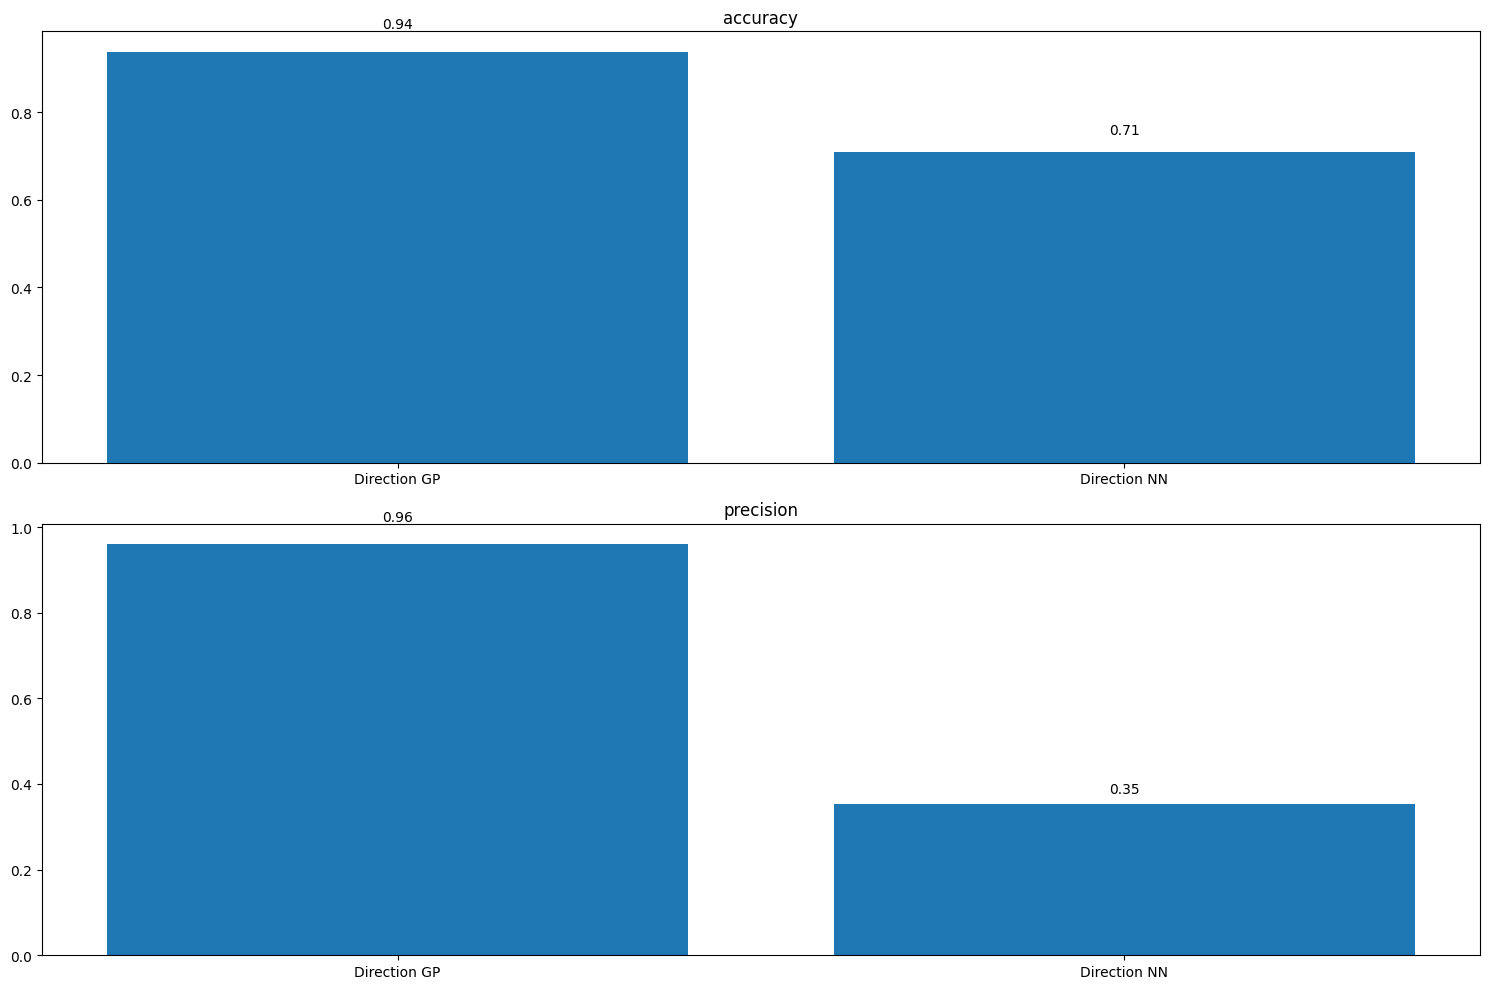

In [ ]:
#plot metrics for continuous targets: price and return
metrics_dir_val= Metrics()
metrics_dir_val.run(test_data['direction'], test_data['direction_gp_pred'], "Direction GP")
metrics_dir_val.run(test_data['direction'], test_data['direction_nn_pred'], "Direction NN")
metrics_dir_val.plot()

#### Logindex Plot

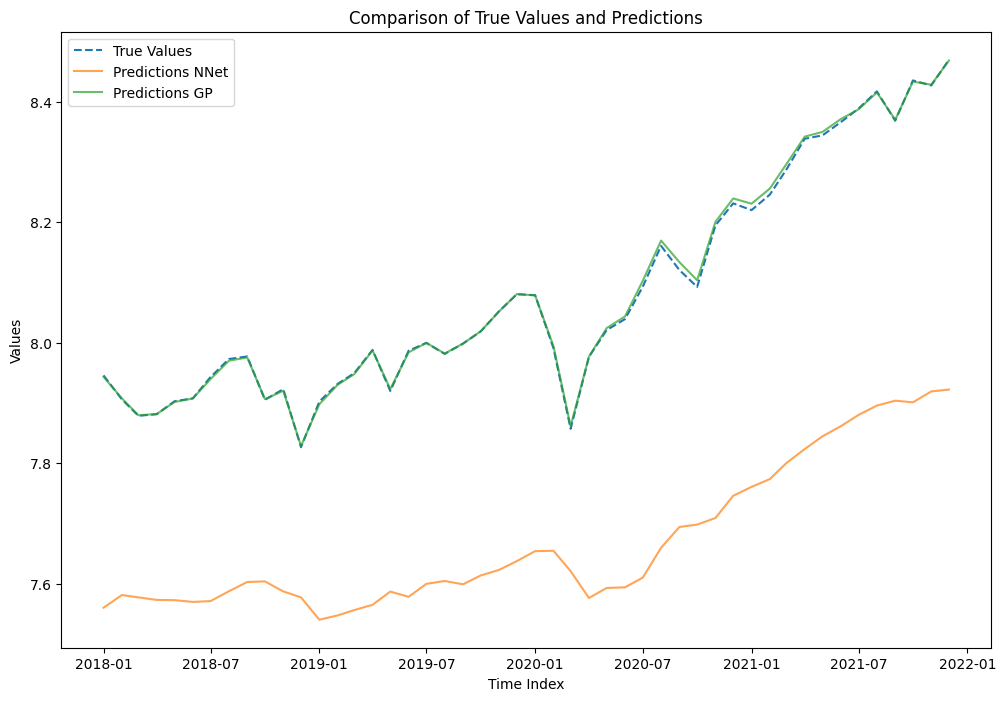

In [ ]:
# Evaluation of Results
df_logindex_res = pd.DataFrame(
    {'true': test_data['logindex'], 'pred_nn': pred_nn['logindex'], 'pred_gp': pred_gp['logindex']}
)

# Assuming 'date' is the name of the column in test_data that contains the date information
df_logindex_res['date'] = test_data.date

# Convert the 'date' column to datetime format
df_logindex_res['date'] = pd.to_datetime(df_logindex_res['date'])

# Set the 'date' column as the index of df_index_res DataFrame
df_logindex_res.set_index('date', inplace=True)

plt.figure(figsize=(12, 8))
plt.plot(df_logindex_res['true'], label='True Values', linestyle='--')
plt.plot(df_logindex_res['pred_nn'], label='Predictions NNet', alpha=0.7)
plt.plot(df_logindex_res['pred_gp'], label='Predictions GP', alpha=0.7)

# Adding labels and title
plt.xlabel('Time Index')
plt.ylabel('Values')
plt.title('Comparison of True Values and Predictions')

# Display legend
plt.legend()

# Show the plot
plt.show()

#### Logret (Returns) Plot

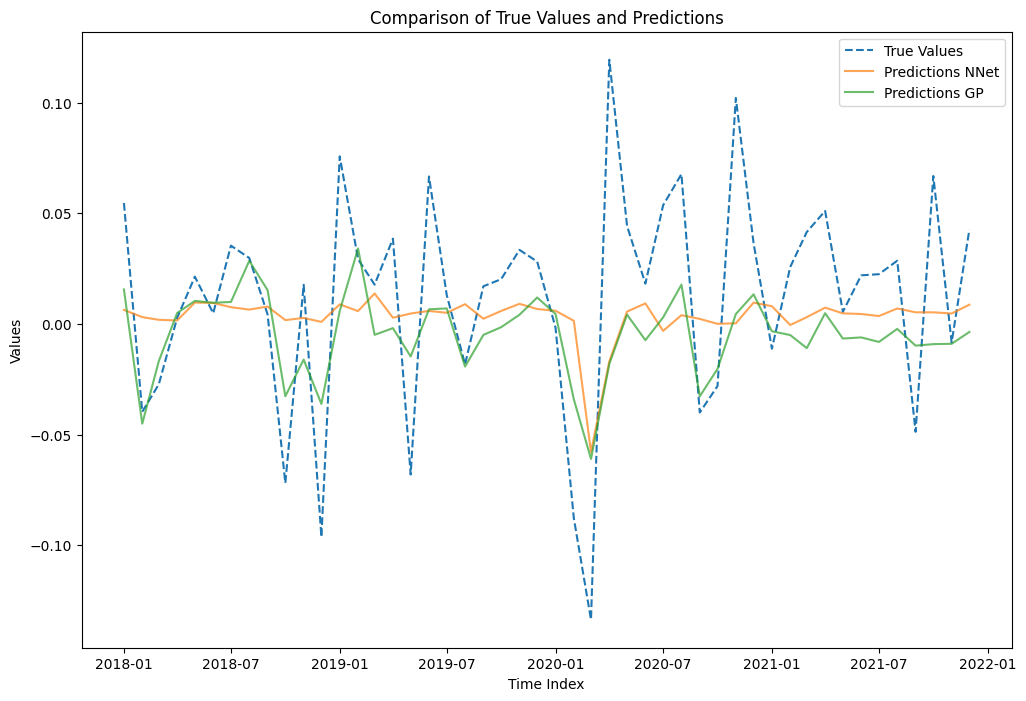

In [ ]:
# Evaluation of Results
df_logret_res = pd.DataFrame(
    {'true': test_data['logret'], 'pred_nn': pred_nn['logret'], 'pred_gp': pred_gp['logret']}
)

# Assuming 'date' is the name of the column in test_data that contains the date information
df_logret_res['date'] = test_data.date

# Convert the 'date' column to datetime format
df_logret_res['date'] = pd.to_datetime(df_logret_res['date'])

# Set the 'date' column as the index of df_index_res DataFrame
df_logret_res.set_index('date', inplace=True)

plt.figure(figsize=(12, 8))
plt.plot(df_logret_res['true'], label='True Values', linestyle='--')
plt.plot(df_logret_res['pred_nn'], label='Predictions NNet', alpha=0.7)
plt.plot(df_logret_res['pred_gp'], label='Predictions GP', alpha=0.7)

# Adding labels and title
plt.xlabel('Time Index')
plt.ylabel('Values')
plt.title('Comparison of True Values and Predictions')

# Display legend
plt.legend()

# Show the plot
plt.show()


#### Direction Plot

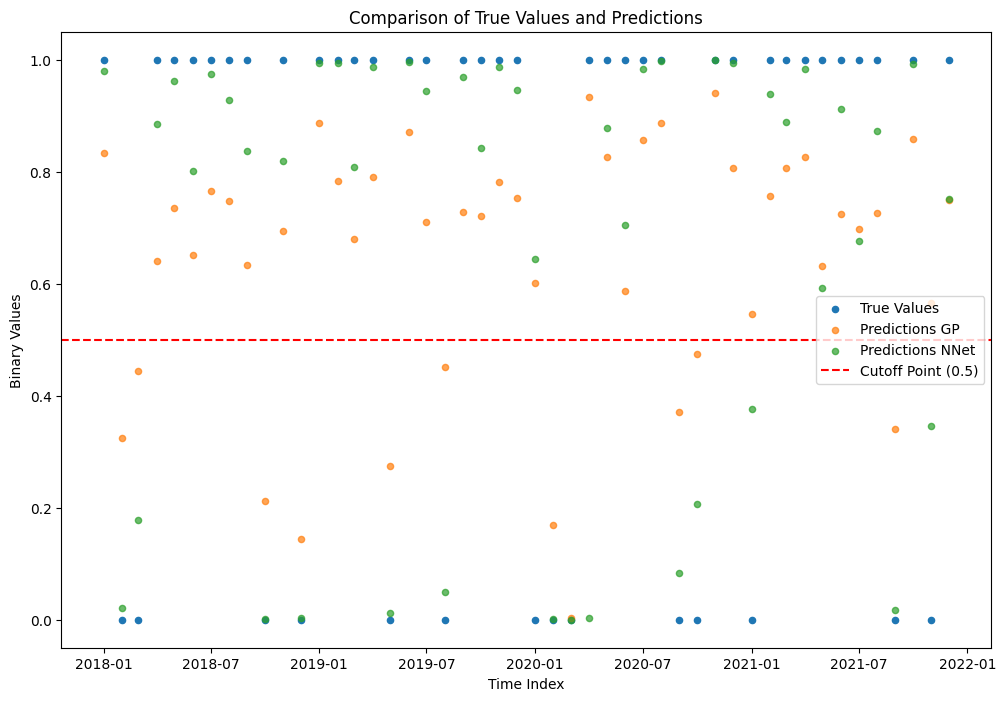

In [ ]:
# Evaluation of Results
df_direction_res = pd.DataFrame(
    {'true': test_data['direction'], 'pred_nn': test_data['direction_nn_prob'], 'pred_gp': test_data['direction_gp_pred_prob']}
)

df_direction_res['date'] = test_data.date
df_direction_res['date'] = pd.to_datetime(df_direction_res['date'])
df_direction_res.set_index('date', inplace=True)

plt.figure(figsize=(12, 8))

# Plot True Values
plt.scatter(df_direction_res.index, df_direction_res['true'], label='True Values', marker='o', s=20)

# Plot Predictions for NNet and GP
plt.scatter(df_direction_res.index, df_direction_res['pred_gp'], label='Predictions GP', alpha=0.7, s=20)
plt.scatter(df_direction_res.index, df_direction_res['pred_nn'], label='Predictions NNet', alpha=0.7, s=20)

# Adding a horizontal line at y=0.5
plt.axhline(y=0.5, color='r', linestyle='--', label='Cutoff Point (0.5)')

# Adding labels and title
plt.xlabel('Time Index')
plt.ylabel('Binary Values')
plt.title('Comparison of True Values and Predictions')

# Display legend
plt.legend()

# Show the plot
plt.show()


### Plots results

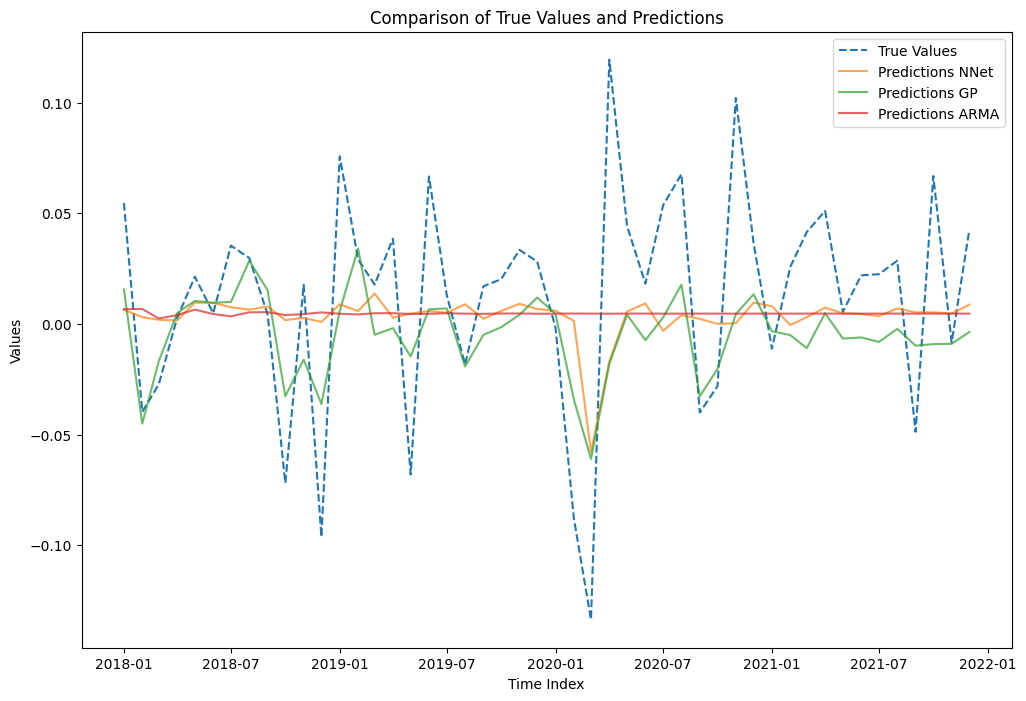

In [ ]:
#Compare ARMA model to NN and Gaussian Process Regression
# Evaluation of Results
df_logret_res = pd.DataFrame(
    {'true': test_data['logret'], 'pred_nn': test_data['logret_nn_pred'], 'pred_gp': test_data['logret_gp_pred'], 'pred_arma': logret_predictions['pred_arma']}
)

# Assuming 'date' is the name of the column in test_data that contains the date information
df_logret_res['date'] = test_data.date

# Convert the 'date' column to datetime format
df_logret_res['date'] = pd.to_datetime(df_logret_res['date'])

# Set the 'date' column as the index of df_index_res DataFrame
df_logret_res.set_index('date', inplace=True)

plt.figure(figsize=(12, 8))
plt.plot(df_logret_res['true'], label='True Values', linestyle='--')
plt.plot(df_logret_res['pred_nn'], label='Predictions NNet', alpha=0.7)
plt.plot(df_logret_res['pred_gp'], label='Predictions GP', alpha=0.7)
plt.plot(df_logret_res['pred_arma'], label='Predictions ARMA', alpha=0.7)

# Adding labels and title
plt.xlabel('Time Index')
plt.ylabel('Values')
plt.title('Comparison of True Values and Predictions')

# Display legend
plt.legend()

# Show the plot
plt.show()

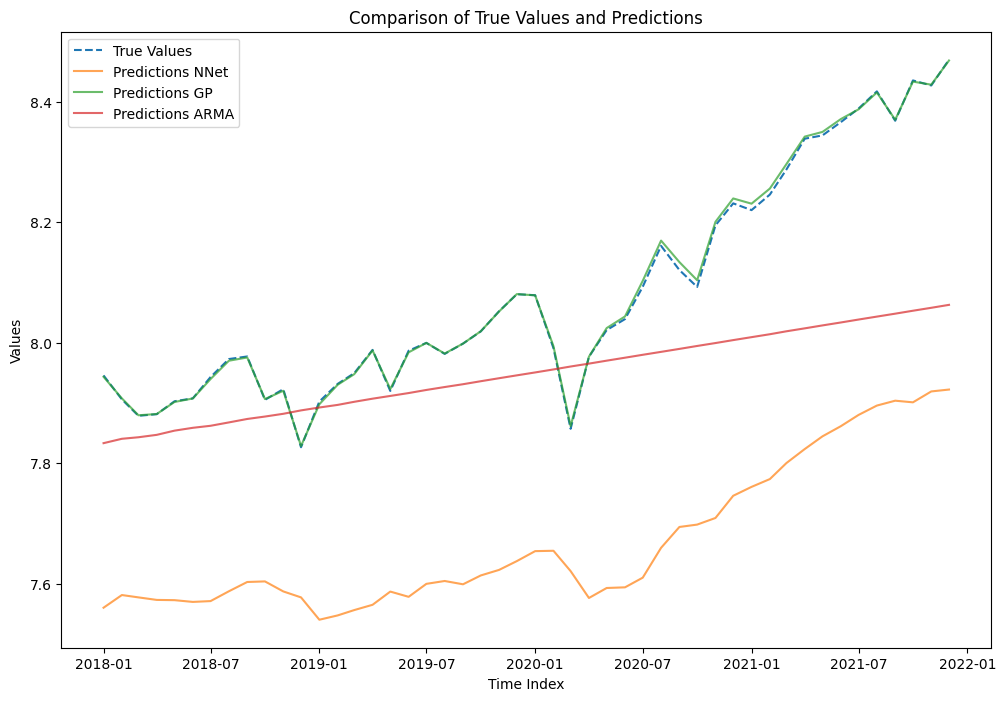

In [ ]:
# Convert 'date' in test_data
#test_data['date'] = pd.to_datetime(test_data['date'])
restored_predictions = restored_predictions.reset_index().rename(columns={'index': 'date'})
restored_predictions['date'] = pd.to_datetime(restored_predictions['date'])  # Adjust 'unit' as necessary

# Evaluation of Results
df_logindex_res = pd.DataFrame(
    {'true': test_data['logindex'], 'pred_nn': test_data['logindex_nn_pred'], 'pred_gp': test_data['logindex_gp_pred'], 'pred_arma': restored_predictions[0]}
)

# Assuming 'date' is the name of the column in test_data that contains the date information
df_logindex_res['date'] = test_data.date

# Convert the 'date' column to datetime format
df_logindex_res['date'] = pd.to_datetime(df_logindex_res['date'])

# Set the 'date' column as the index of df_index_res DataFrame
df_logindex_res.set_index('date', inplace=True)

plt.figure(figsize=(12, 8))
plt.plot(df_logindex_res['true'], label='True Values', linestyle='--')
plt.plot(df_logindex_res['pred_nn'], label='Predictions NNet', alpha=0.7)
plt.plot(df_logindex_res['pred_gp'], label='Predictions GP', alpha=0.7)
plt.plot(df_logindex_res['pred_arma'], label='Predictions ARMA', alpha=0.7)

# Adding labels and title
plt.xlabel('Time Index')
plt.ylabel('Values')
plt.title('Comparison of True Values and Predictions')

# Display legend
plt.legend()

# Show the plot
plt.show()

In [ ]:
#Stationary Bootstrapping


In [ ]:
#Modeling with Stationary Bootstrapping (if necessary)
